# Data

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime

# Read data
df = pd.read_csv('E:/Dashboard/data-1769423129972.csv')

# Extract date (format: MM-DD)
df['date'] = df['end_time'].str.slice(5, 10)  # Extract MM-DD format

# Display available dates for selection
print("Available dates:")
available_dates = sorted(df['date'].dropna().unique())
for i, date in enumerate(available_dates):
    print(f"{i+1}. {date}")

# Manual input for date to analyze
selected_date = input("\nPlease enter the date to analyze (format MM-DD, e.g., 01-08): ")

# Filter data for selected date
df_filtered = df[df['date'] == selected_date].copy()

# Filter status
df_filtered = df_filtered[df_filtered['StatusName'].isin(['Completed', 'On-Hold'])]

print(f"\n{selected_date} Data Overview:")
print(f"Total records: {len(df_filtered)}")
print(f"Completed: {len(df_filtered[df_filtered['StatusName'] == 'Completed'])}")
print(f"On-Hold: {len(df_filtered[df_filtered['StatusName'] == 'On-Hold'])}")

Available dates:
1. 01-07
2. 01-08
3. 01-09
4. 01-12
5. 01-13
6. 01-14
7. 01-15
8. 01-16
9. 01-17
10. 01-19
11. 01-20
12. 01-21
13. 01-22
14. 01-23
15. 01-24
16. 12-12
17. 12-17
18. 12-18
19. 12-19
20. 12-22

01-23 Data Overview:
Total records: 486
Completed: 413
On-Hold: 73


In [15]:
# Data processing strategy: Time-related metrics will cap abnormal time records at 15 minutes
print("Data Processing Strategy:")
print(f"Complete records: {len(df_filtered)}")
df_time_filtered = df_filtered.copy()
# Cap time at 15 minutes for time-related calculations
df_time_filtered['total_time(minutes)'] = df_time_filtered['total_time(minutes)'].clip(upper=15)
abnormal_count = len(df_filtered[df_filtered['total_time(minutes)'] > 15])
print(f"All records used for time metrics (time >15 min capped at 15): {len(df_time_filtered)}")
print(f"Records with time >15 minutes (capped): {abnormal_count}")

# Get all user list
users = sorted(df_filtered['UserName'].unique())
print(f"\nFound users: {', '.join(users)}")

# Option to exclude users from analysis
print("\n=== User Exclusion (Optional) ===")
exclude_input = input("Enter usernames to exclude from analysis (comma-separated, or press Enter to skip): ")
excluded_users = []
if exclude_input.strip():
    excluded_users = [name.strip() for name in exclude_input.split(',')]
    print(f"Excluded users: {excluded_users}")
    # Remove excluded users
    users = [user for user in users if user not in excluded_users]
    df_filtered = df_filtered[~df_filtered['UserName'].isin(excluded_users)]
    df_time_filtered = df_time_filtered[~df_time_filtered['UserName'].isin(excluded_users)]
    print(f"Remaining users for analysis: {', '.join(users)}")

# Manual input of target values for each user
user_targets = {}
print("\nPlease set performance targets for each user:")
print("Note: If a user has no target, enter 'n/a' or 'n'")

def parse_target_input(input_str, target_type):
    """Parse target input, handle non-numeric cases"""
    input_str = input_str.strip().lower()
    if input_str in ['n/a', 'n', 'na', 'none', '']:
        return None
    try:
        return float(input_str)
    except ValueError:
        print(f"Invalid input '{input_str}', will be treated as no target")
        return None

for user in users:
    print(f"\n=== {user} ===")
    target_time_input = input(f"{user}'s target working time (minutes, enter n/a if no target): ")
    target_charges_input = input(f"{user}'s target charges amount (enter n/a if no target): ")
    
    target_time = parse_target_input(target_time_input, "time")
    target_charges = parse_target_input(target_charges_input, "charges")
    
    user_targets[user] = {'time': target_time, 'charges': target_charges}

# Calculate detailed performance statistics by UserName
user_stats = []

for user in users:
    # Complete data (for charge metrics)
    user_data_full = df_filtered[df_filtered['UserName'] == user]
    # Time filtered data (for time metrics)
    user_data_time = df_time_filtered[df_time_filtered['UserName'] == user]
    
    # Charge statistics based on complete data
    completed_data_full = user_data_full[user_data_full['StatusName'] == 'Completed']
    onhold_data_full = user_data_full[user_data_full['StatusName'] == 'On-Hold']
    
    # Time statistics based on time-filtered data
    completed_data_time = user_data_time[user_data_time['StatusName'] == 'Completed']
    
    # Get user's target values
    user_target = user_targets[user]
    
    # Calculate actual time (based on filtered data)
    actual_time = completed_data_time['total_time(minutes)'].sum()
    
    # Calculate average time per charge (based on time-filtered data)
    completed_charges_count = len(completed_data_time)  # Number of completed charges (time-filtered)
    if completed_charges_count > 0 and actual_time > 0:
        avg_time_per_charge = f"{(actual_time / completed_charges_count):.1f} min"
    else:
        avg_time_per_charge = "N/A"
    
    # Calculate related metrics, handle None target values
    if user_target['time'] is not None and user_target['time'] > 0:
        time_utilization = f"{(actual_time / user_target['time'] * 100):.1f}%"
    else:
        time_utilization = "N/A"
    
    if user_target['charges'] is not None and user_target['charges'] > 0:
        achievement_rate = f"{(user_data_full['TotalCharges'].sum() / user_target['charges'] * 100):.1f}%"
    else:
        achievement_rate = "N/A"
    
    # Performance statistics
    stats = {
        'UserName': user,
        'BatchNames': ', '.join(user_data_full['BatchName'].unique()[:3]),  # Based on complete data
        'Date': selected_date,
        'Charges_Completed': completed_data_full['TotalCharges'].sum(),  # Based on complete data
        'Charges_OnHold': onhold_data_full['TotalCharges'].sum(),  # Based on complete data
        'Total_Charges': user_data_full['TotalCharges'].sum(),  # Based on complete data
        'Target_Time': user_target['time'] if user_target['time'] is not None else "N/A",
        'Target_Charges': user_target['charges'] if user_target['charges'] is not None else "N/A",
        'Time_Utilization': time_utilization,  # Renamed from Time_Spent_on_Tool
        'Achievement_Rate': achievement_rate,  # Renamed from Efficiency
        'Avg_Time_Per_Charge': avg_time_per_charge  # Average time per completed charge
    }
    
    user_stats.append(stats)

# Create DataFrame
performance_df = pd.DataFrame(user_stats)

print(f"\n{selected_date} Performance Statistics Table Generated!")
print("Note: Time metrics based on normal time records, charge metrics based on complete records")
print("Note: N/A displayed for users without targets")
if excluded_users:
    print(f"Note: Excluded users from analysis: {', '.join(excluded_users)}")

Data Processing Strategy:
Complete records: 486
All records used for time metrics (time >15 min capped at 15): 486
Records with time >15 minutes (capped): 99

Found users: Daniel Leigh, Katie Smith, Kritika Adhikari, Mahsa Abdolshahnejad, Nikhil Muneshwar, Saisruthi Dinesh, Shanthipriya Ninganola, Yishan Zhang, christopher bray, jay teale, morna.nandaia, stefanos korakakis, tima taromsari, will staig

=== User Exclusion (Optional) ===

Please set performance targets for each user:
Note: If a user has no target, enter 'n/a' or 'n'

=== Daniel Leigh ===

=== Katie Smith ===

=== Kritika Adhikari ===

=== Mahsa Abdolshahnejad ===

=== Nikhil Muneshwar ===

=== Saisruthi Dinesh ===

=== Shanthipriya Ninganola ===

=== Yishan Zhang ===

=== christopher bray ===

=== jay teale ===

=== morna.nandaia ===

=== stefanos korakakis ===

=== tima taromsari ===

=== will staig ===

01-23 Performance Statistics Table Generated!
Note: Time metrics based on normal time records, charge metrics based on

In [17]:
# Display simplified performance statistics table
print("=== Performance Statistics Table ===")
display_cols = ['UserName', 'BatchNames', 'Date', 'Time_Utilization',
                'Charges_Completed', 'Charges_OnHold', 'Total_Charges', 'Target_Charges', 
                'Achievement_Rate', 'Avg_Time_Per_Charge']

print(performance_df[display_cols].to_string(index=False))

# Save to Excel file (exclude internal calculation columns)
output_filename = f'Performance_Report_{selected_date.replace("-", "")}.xlsx'
columns_to_exclude = ['Achievement_Value', 'Time_Value', 'Achievement_Rank', 'Charges_Rank', 'Achievement_Grade']
clean_performance_df = performance_df.drop(columns=[col for col in columns_to_exclude if col in performance_df.columns])
clean_performance_df.to_excel(output_filename, index=False)
print(f"\nPerformance report saved to: {output_filename}")

# Display key metrics summary
print("\n=== Key Metrics Summary ===")
total_completed_charges = performance_df['Charges_Completed'].sum()
total_onhold_charges = performance_df['Charges_OnHold'].sum()
total_charges = performance_df['Total_Charges'].sum()

print(f"Total Completed Task Charges: {total_completed_charges:.2f}")
print(f"Total On-Hold Task Charges: {total_onhold_charges:.2f}")
print(f"Total Charges Amount: {total_charges:.2f}")

# Calculate average achievement rate (remove % symbol and calculate, excluding N/A values)
achievement_values = []

time_util_values = []

for rate in performance_df['Achievement_Rate']:
    if rate != "N/A":
        achievement_values.append(float(rate.replace('%', '')))

for time_val in performance_df['Time_Utilization']:
    if time_val != "N/A":
        time_util_values.append(float(time_val.replace('%', '')))

if achievement_values:
    print(f"Average Achievement Rate: {sum(achievement_values) / len(achievement_values):.1f}% (based on {len(achievement_values)} users with targets)")
else:
    print("Average Achievement Rate: N/A (all users have no charge targets)")

if time_util_values:
    print(f"Average Time Utilization: {sum(time_util_values) / len(time_util_values):.1f}% (based on {len(time_util_values)} users with targets)")

else:    print("Average Time Utilization: N/A (all users have no time targets)")

=== Performance Statistics Table ===
              UserName               BatchNames  Date Time_Utilization  Charges_Completed  Charges_OnHold  Total_Charges Target_Charges Achievement_Rate Avg_Time_Per_Charge
          Daniel Leigh CRAWLEYBOROUGHCOUNCIL_94 01-23              N/A                 15               0             15            N/A              N/A            13.3 min
           Katie Smith CRAWLEYBOROUGHCOUNCIL_94 01-23              N/A                  4               0              4            N/A              N/A            11.3 min
      Kritika Adhikari CRAWLEYBOROUGHCOUNCIL_94 01-23              N/A                 91               0             91            N/A              N/A             4.7 min
  Mahsa Abdolshahnejad CRAWLEYBOROUGHCOUNCIL_94 01-23              N/A                 46               0             46            N/A              N/A             5.9 min
      Nikhil Muneshwar CRAWLEYBOROUGHCOUNCIL_94 01-23              N/A                 89         

In [7]:
df_f = pd.read_excel('E:/Dashboard/Team.xlsx') 

In [8]:
df_f.head(10)     

,First Name,Last Name,Role,Team Function
0,Harinath,Neeli,Project Manager - Quality,Tech Enabler
1,Michael,Uchechukwu Egwim,Pilot & Transition Lead,Tech Enabler
2,Bhagirathsinh,Matroja,Technical Enabler,Tech Enabler
3,Jia,Zhao,Technical Enabler,Tech Enabler
4,Yishan,Zhang,Technical Enabler,Tech Enabler
5,Ramya,Manne Sai,Technical Enabler,Tech Enabler
6,Morna,Nandaia,Delivery Pod Lead,Delivery - A
7,Shahir,Qureshi,Lead GIS Data Engineer,Delivery - A
8,Lorna,Anne Boland,Data Engineer,Delivery - A
9,Hermione,Clarke,Data Engineer,Delivery - A


## Performance Table Documentation

### Table Column Descriptions:
- **UserName**: Employee name
- **BatchNames**: Batch names processed (showing first 3)
- **Date**: Analysis date
- **Time_Utilization**: Time utilization ratio (actual time/target time × 100%)*
- **Charges_Completed**: Total charges for completed tasks
- **Charges_OnHold**: Total charges for on-hold tasks  
- **Total_Charges**: Total charges amount (completed + on-hold)
- **Target_Charges**: Personal target charges amount
- **Achievement_Rate**: Target completion rate (total charges/target charges × 100%)
- **Avg_Time_Per_Charge**: Average time spent completing each charge (total time/completed charges)*

### Important Data Processing Notes:
**Metrics marked with * are based on time-capped data (time >15 minutes is capped at 15 minutes)**
**Other charge-related metrics are based on complete data (including all records)**

### Core Metrics Explanation:
1. **Achievement_Rate**: Target completion rate (based on complete data), measuring performance against targets
2. **Time_Utilization**: Time usage ratio (based on time-capped data), evaluating working time allocation

### Data Processing Strategy:
- **Time Metrics**: Automatically cap work time records >15 minutes at 15 minutes (avoiding system delay impact on time analysis)
- **Charge Metrics**: Based on complete data statistics (ensuring charge data integrity)
- **Personal Targets**: Each employee can set different target time and target charges
- **Percentage Display**: Target completion rate and time utilization displayed in percentage format

### Performance Evaluation Guidelines:
- **Achievement Rate**: 100%+ meets standard, 120%+ is excellent
- **Time Utilization**: Close to 100% is ideal, too high may need workflow optimization
- **Charge Composition**: Monitor On-Hold task ratio, too high may need process improvement

**Note: Time values >15 minutes are automatically capped at 15 minutes for time-related calculations**

In [17]:
# Optional: Calculate additional performance rankings and analysis
# Extract numerical values for ranking calculation (excluding N/A values)
achievement_numerical = []
time_numerical = []

for idx, row in performance_df.iterrows():
    # Process Achievement_Rate
    if row['Achievement_Rate'] != "N/A":
        achievement_numerical.append(float(row['Achievement_Rate'].replace('%', '')))
    else:
        achievement_numerical.append(None)
    
    # Process Time_Utilization
    if row['Time_Utilization'] != "N/A":
        time_numerical.append(float(row['Time_Utilization'].replace('%', '')))
    else:
        time_numerical.append(None)

performance_df['Achievement_Value'] = achievement_numerical
performance_df['Time_Value'] = time_numerical

# Calculate rankings (only for users with numerical values)
performance_df['Achievement_Rank'] = performance_df['Achievement_Value'].rank(ascending=False, method='min')
performance_df['Charges_Rank'] = performance_df['Charges_Completed'].rank(ascending=False, method='min')

# Calculate achievement grade
def get_achievement_grade(rate):
    if rate is None:
        return "No Target"
    elif rate >= 120:
        return "Excellent"
    elif rate >= 100:
        return "Meets Standard" 
    elif rate >= 80:
        return "Good"
    else:
        return "Needs Improvement"

performance_df['Achievement_Grade'] = performance_df['Achievement_Value'].apply(get_achievement_grade)

print("=== Performance Rankings and Grade Analysis ===")
ranking_cols = ['UserName', 'Achievement_Rate', 'Achievement_Grade', 
                'Charges_Completed', 'Time_Utilization']

print(performance_df[ranking_cols].to_string(index=False))

# Save comprehensive report (exclude internal calculation columns)
enhanced_filename = f'Comprehensive_Performance_Report_{selected_date.replace("-", "")}.xlsx'
# Create a clean dataframe without internal calculation columns
columns_to_exclude = ['Achievement_Value', 'Time_Value', 'Achievement_Rank', 'Charges_Rank']
clean_performance_df = performance_df.drop(columns=[col for col in columns_to_exclude if col in performance_df.columns])
clean_performance_df.to_excel(enhanced_filename, index=False)
print(f"\nComprehensive performance report saved to: {enhanced_filename}")

# Performance summary
print("\n=== Performance Summary ===")
# Only count users with targets
users_with_targets = performance_df[performance_df['Achievement_Value'].notna()]
users_without_targets = performance_df[performance_df['Achievement_Value'].isna()]

if len(users_with_targets) > 0:
    excellent_users = users_with_targets[users_with_targets['Achievement_Value'] >= 120]['UserName'].tolist()
    good_users = users_with_targets[(users_with_targets['Achievement_Value'] >= 100) & 
                                   (users_with_targets['Achievement_Value'] < 120)]['UserName'].tolist()
    needs_improvement = users_with_targets[users_with_targets['Achievement_Value'] < 80]['UserName'].tolist()

    if excellent_users:
        print(f"High Performance (≥120%): {', '.join(excellent_users)}")
    if good_users:
        print(f"Target Met (≥100%): {', '.join(good_users)}")
    if needs_improvement:
        print(f"Below Target (<80%): {', '.join(needs_improvement)}")

if len(users_without_targets) > 0:
    no_target_users = users_without_targets['UserName'].tolist()
    print(f"Users Without Charge Targets: {', '.join(no_target_users)}")

=== Performance Rankings and Grade Analysis ===
              UserName Achievement_Rate Achievement_Grade  Charges_Completed Time_Utilization
          Daniel Leigh            60.0% Needs Improvement                 32            75.3%
           Katie Smith              N/A Needs Improvement                 10              N/A
      Kritika Adhikari            96.0%              Good                 70            88.2%
  Mahsa Abdolshahnejad            56.0% Needs Improvement                 38            95.3%
      Nikhil Muneshwar            78.7% Needs Improvement                 44            53.5%
      Saisruthi Dinesh            66.7% Needs Improvement                 50            41.4%
Shanthipriya Ninganola            82.7%              Good                 53           101.6%
          Syed Bhukari           129.3%         Excellent                 90            84.5%
       bhagirathsinh.m           122.7%         Excellent                 61            53.9%
            

In [18]:
# Advanced Performance Metrics Analysis
print("=== Advanced Performance Metrics Analysis ===\n")

# 1. Charge Efficiency Analysis (based on time-capped data)
print("1. Charge Efficiency Metrics (based on time-capped data):")
print("   - Analysis based on charge completion efficiency (time >15 min capped at 15)")

print("\n2. Data Quality Analysis:")
print("   - Time values >15 minutes capped at 15 for calculations")
for user in users:
    user_data_full = df_filtered[df_filtered['UserName'] == user]
    
    # Count records with original time >15 minutes
    abnormal_records = len(user_data_full[user_data_full['total_time(minutes)'] > 15])
    total_records = len(user_data_full)
    
    if abnormal_records > 0:
        abnormal_ratio = (abnormal_records / total_records) * 100
        print(f"   - {user}: {abnormal_records}/{total_records} records with time >15 min ({abnormal_ratio:.1f}%)")
    else:
        print(f"   - {user}: No records with time >15 minutes")

print("\n3. Work Quality vs Achievement Balance:")
print("   - Comprehensive assessment based on On-Hold ratio and achievement rate")
for idx, row in performance_df.iterrows():
    if row['Achievement_Rate'] != "N/A":
        achievement_val = float(row['Achievement_Rate'].replace('%', ''))
        onhold_ratio = row['Charges_OnHold'] / row['Total_Charges'] * 100 if row['Total_Charges'] > 0 else 0
        
        if achievement_val >= 100 and onhold_ratio <= 10:
            quality_balance = "Optimal Balance"
        elif achievement_val >= 100:
            quality_balance = "High Achievement - Monitor Quality"
        elif onhold_ratio <= 10:
            quality_balance = "Quality Focus"
        else:
            quality_balance = "Overall Improvement Needed"
        print(f"   - {row['UserName']}: {quality_balance} (On-Hold: {onhold_ratio:.1f}%)")
    else:
        onhold_ratio = row['Charges_OnHold'] / row['Total_Charges'] * 100 if row['Total_Charges'] > 0 else 0
        print(f"   - {row['UserName']}: No charge target (On-Hold: {onhold_ratio:.1f}%)")

print("\n4. Potential Improvement Areas:")
print("   - Process bottleneck analysis based on On-Hold tasks")
for idx, row in performance_df.iterrows():
    onhold_ratio = row['Charges_OnHold'] / row['Total_Charges'] * 100 if row['Total_Charges'] > 0 else 0
    if onhold_ratio > 20:
        improvement = "High Priority - Reduce On-Hold tasks"
    elif onhold_ratio > 10:
        improvement = "Medium Priority - Optimize process"
    else:
        improvement = "Good - Maintain current status"
    print(f"   - {row['UserName']}: On-Hold ratio {onhold_ratio:.1f}% - {improvement}")

print("\n5. Target Setting Recommendations:")
print("   - Performance management recommendations for users without targets")
users_without_targets = performance_df[performance_df['Achievement_Rate'] == "N/A"]['UserName'].tolist()
if users_without_targets:
    print(f"   - Recommend setting targets for: {', '.join(users_without_targets)}")
    print("   - Can base on team average or historical data to set reasonable targets")
else:
    print("   - All users have targets set")

if excluded_users:
    print(f"\n6. Excluded Users: {', '.join(excluded_users)}")
    print("   - These users were excluded from all analysis and calculations")

=== Advanced Performance Metrics Analysis ===

1. Charge Efficiency Metrics (based on time-capped data):
   - Analysis based on charge completion efficiency (time >15 min capped at 15)

2. Data Quality Analysis:
   - Time values >15 minutes capped at 15 for calculations
   - Daniel Leigh: 14/36 records with time >15 min (38.9%)
   - Katie Smith: 8/10 records with time >15 min (80.0%)
   - Kritika Adhikari: 3/72 records with time >15 min (4.2%)
   - Mahsa Abdolshahnejad: 9/42 records with time >15 min (21.4%)
   - Nikhil Muneshwar: 7/59 records with time >15 min (11.9%)
   - Saisruthi Dinesh: 8/50 records with time >15 min (16.0%)
   - Shanthipriya Ninganola: 5/62 records with time >15 min (8.1%)
   - Syed Bhukari: 5/97 records with time >15 min (5.2%)
   - bhagirathsinh.m: 5/92 records with time >15 min (5.4%)
   - jay teale: 4/80 records with time >15 min (5.0%)
   - meenakshi.singh: 2/8 records with time >15 min (25.0%)
   - morna.nandaia: 6/56 records with time >15 min (10.7%)
   - 

# visualization

In [14]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for better display
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False

# Try to set font that supports characters properly
try:
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica']
except:
    pass

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Define color scheme for achievement grades
GRADE_COLORS = {
    'Excellent': '#2ecc71',           # Green
    'Meets Standard': '#3498db',      # Blue
    'Good': '#f39c12',                # Orange
    'Needs Improvement': '#e74c3c',   # Red
    'No Target': '#95a5a6'            # Gray
}

# Helper function to extract first name
def get_first_name(full_name):
    """Extract first name from full name (assumes format: 'FirstName LastName')"""
    return full_name.split()[0] if isinstance(full_name, str) and full_name.strip() else full_name

# Create first names list for visualization
first_names = [get_first_name(name) for name in performance_df['UserName'].tolist()]

print("Visualization libraries loaded successfully!")
print(f"Using performance_df with {len(performance_df)} users")
print(f"First names for charts: {', '.join(first_names)}")

Visualization libraries loaded successfully!
Using performance_df with 15 users
First names for charts: Daniel, Katie, Kritika, Mahsa, Nikhil, Saisruthi, Shanthipriya, Syed, bhagirathsinh.m, jay, meenakshi.singh, morna.nandaia, stefanos, tima, will


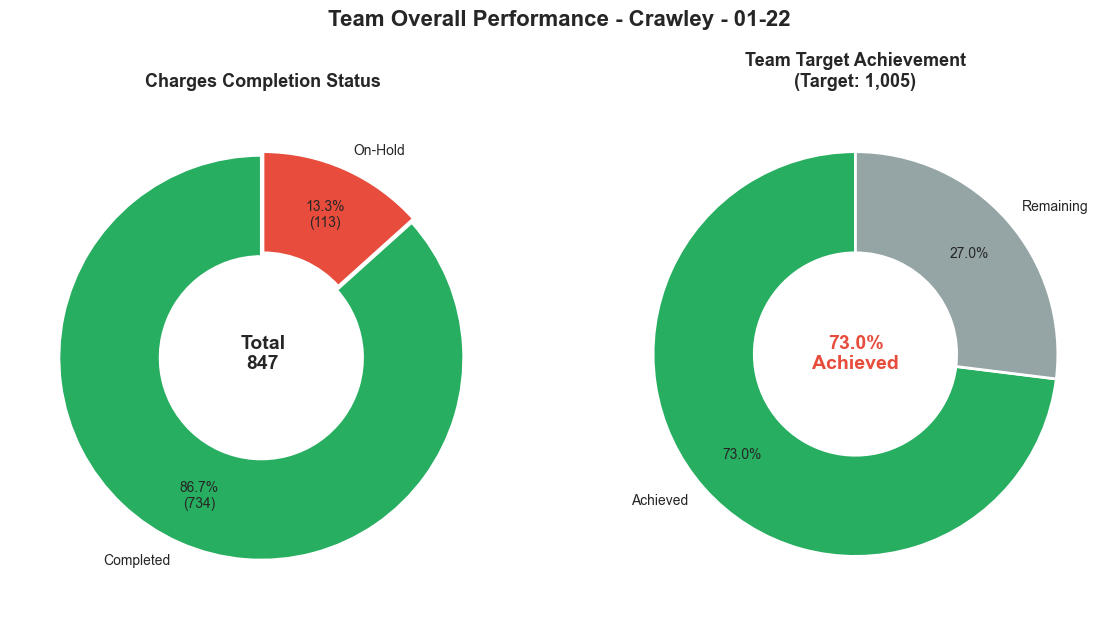


TEAM SUMMARY
Total Completed Charges: 734.00
Total On-Hold Charges: 113.00
Total Target (from 14 users): 1,005.00
Team Achievement Rate: 73.0%


In [15]:
# Chart 0: Team Overall Performance Summary (Donut Chart)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Calculate team totals
total_completed = performance_df['Charges_Completed'].sum()
total_onhold = performance_df['Charges_OnHold'].sum()
total_all = total_completed + total_onhold

# Get total target (only from users with targets)
total_target = 0
users_with_target_count = 0
for val in performance_df['Target_Charges']:
    if val != "N/A":
        total_target += float(val)
        users_with_target_count += 1

# === Panel 1: Completed vs On-Hold (Donut) ===
ax1 = axes[0]
sizes1 = [total_completed, total_onhold]
labels1 = ['Completed', 'On-Hold']
colors1 = ['#27ae60', '#e74c3c']
explode1 = (0.02, 0)

# Create custom labels with actual values
def make_autopct(values):
    def my_autopct(pct):
        absolute = int(round(pct/100.*sum(values)))
        return f'{pct:.1f}%\n({absolute:,.0f})'
    return my_autopct

wedges1, texts1, autotexts1 = ax1.pie(sizes1, labels=labels1, colors=colors1, 
                                       autopct=make_autopct(sizes1), startangle=90, explode=explode1,
                                       pctdistance=0.75,
                                       wedgeprops={'width': 0.5, 'edgecolor': 'white', 'linewidth': 2})
ax1.text(0, 0, f'Total\n{total_all:,.0f}', ha='center', va='center', fontsize=14, fontweight='bold')
ax1.set_title('Charges Completion Status', fontsize=13, fontweight='bold', pad=10)

# === Panel 2: Target Achievement (Donut) ===
ax2 = axes[1]
if total_target > 0:
    achieved = min(total_completed, total_target)
    remaining = max(0, total_target - total_completed)
    exceeded = max(0, total_completed - total_target)
    
    if exceeded > 0:
        # Exceeded target
        sizes2 = [total_target, exceeded]
        labels2 = ['Target Met', 'Exceeded']
        colors2 = ['#3498db', '#2ecc71']
        achievement_pct = (total_completed / total_target) * 100
    else:
        # Not yet met target
        sizes2 = [achieved, remaining]
        labels2 = ['Achieved', 'Remaining']
        colors2 = ['#27ae60', '#95a5a6']
        achievement_pct = (total_completed / total_target) * 100
    
    wedges2, texts2, autotexts2 = ax2.pie(sizes2, labels=labels2, colors=colors2,
                                           autopct='%1.1f%%', startangle=90,
                                           pctdistance=0.75,
                                           wedgeprops={'width': 0.5, 'edgecolor': 'white', 'linewidth': 2})
    ax2.text(0, 0, f'{achievement_pct:.1f}%\nAchieved', ha='center', va='center', fontsize=14, fontweight='bold',
             color='#27ae60' if achievement_pct >= 100 else '#e74c3c')
else:
    ax2.text(0.5, 0.5, 'No Target Set', ha='center', va='center', fontsize=14, transform=ax2.transAxes)
ax2.set_title(f'Team Target Achievement\n(Target: {total_target:,.0f})', fontsize=13, fontweight='bold', pad=10)



fig.suptitle(f'Team Overall Performance - Crawley - {selected_date}', fontsize=16, fontweight='bold', y=1.02) ##### Change the name
plt.tight_layout()
plt.savefig(f'Team_Summary_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary stats
print("\n" + "="*60)
print("TEAM SUMMARY")
print("="*60)
print(f"Total Completed Charges: {total_completed:,.2f}")
print(f"Total On-Hold Charges: {total_onhold:,.2f}")
print(f"Total Target (from {users_with_target_count} users): {total_target:,.2f}")

if total_target > 0:
    print(f"Team Achievement Rate: {(total_completed/total_target)*100:.1f}%")
print("="*60)

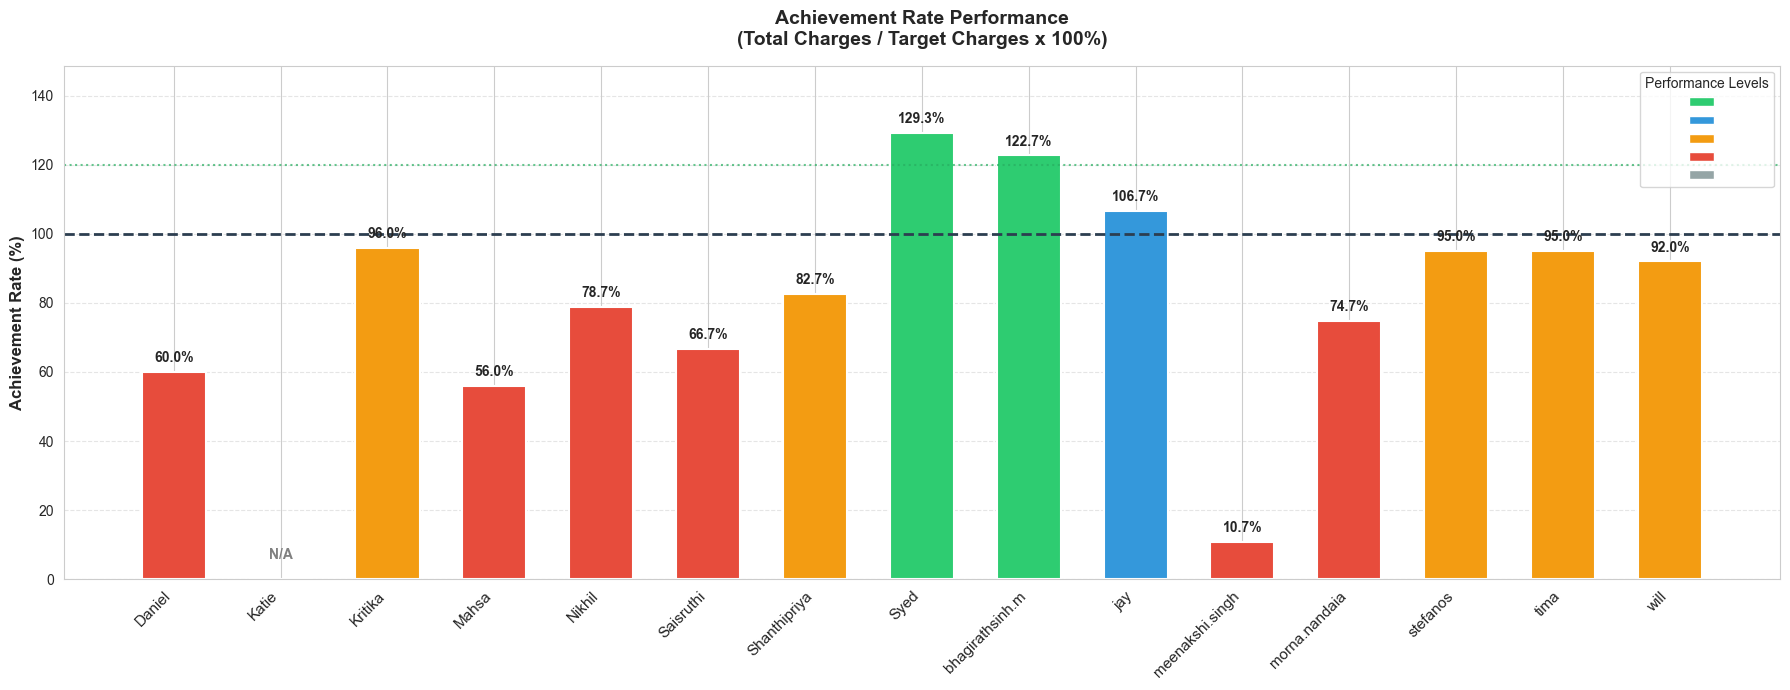

In [19]:
# Chart 1: Achievement Rate Bar Chart
fig, ax = plt.subplots(figsize=(max(10, len(performance_df) * 1.2), 7))

achievement_values = []
colors = []

for idx, row in performance_df.iterrows():
    if row['Achievement_Rate'] != "N/A":
        achievement_values.append(float(row['Achievement_Rate'].replace('%', '')))
    else:
        achievement_values.append(0)
    colors.append(GRADE_COLORS.get(row['Achievement_Grade'], GRADE_COLORS['No Target']))

x_pos = np.arange(len(first_names))
bars = ax.bar(x_pos, achievement_values, color=colors, edgecolor='white', linewidth=1.5, width=0.6)

ax.axhline(y=100, color='#2c3e50', linestyle='--', linewidth=2, label='Target (100%)')
ax.axhline(y=120, color='#27ae60', linestyle=':', linewidth=1.5, alpha=0.7, label='Excellence (120%)')

for i, (bar, val) in enumerate(zip(bars, achievement_values)):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width()/2, 5, 'N/A', 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='gray')

ax.set_xticks(x_pos)
ax.set_xticklabels(first_names, fontsize=11, rotation=45, ha='right')
ax.set_ylabel('Achievement Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Achievement Rate Performance\n(Total Charges / Target Charges x 100%)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylim(0, max(achievement_values) * 1.15 if max(achievement_values) > 0 else 150)

# Create legend without text labels - only colors
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color) 
                   for grade, color in GRADE_COLORS.items()]
ax.legend(handles=legend_elements, loc='upper right', title='Performance Levels', fontsize=9, 
          labels=['', '', '', '', ''])  # Empty labels
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'Achievement_Rate_Chart_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

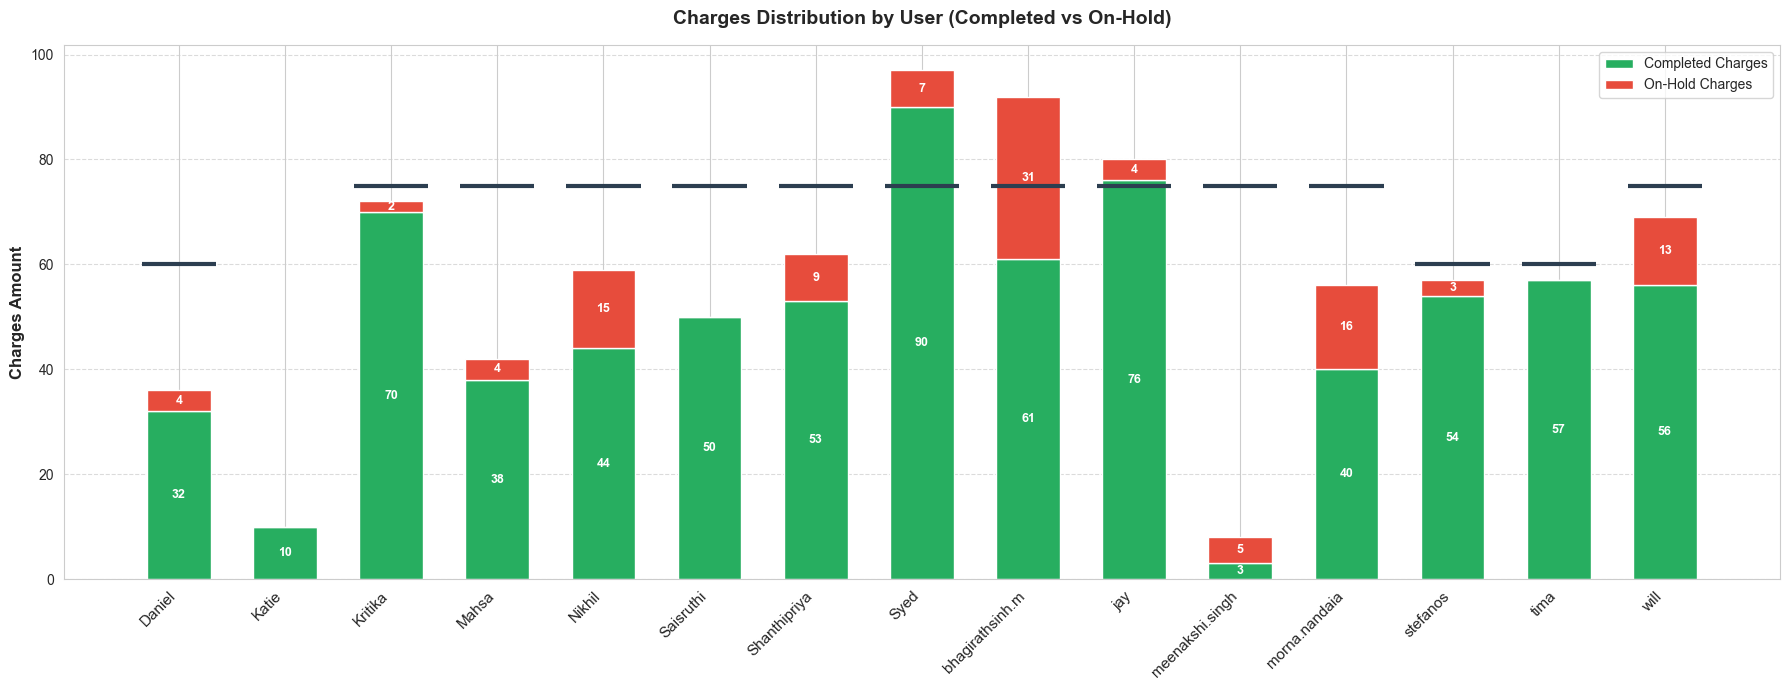

In [20]:
# Chart 2: Charges Distribution Stacked Bar Chart
fig, ax = plt.subplots(figsize=(max(10, len(performance_df) * 1.2), 7))

completed_charges = performance_df['Charges_Completed'].tolist()
onhold_charges = performance_df['Charges_OnHold'].tolist()

target_charges = []
for val in performance_df['Target_Charges']:
    target_charges.append(float(val) if val != "N/A" else None)

x_pos = np.arange(len(first_names))
width = 0.6

bars1 = ax.bar(x_pos, completed_charges, width, label='Completed Charges', 
               color='#27ae60', edgecolor='white', linewidth=1)
bars2 = ax.bar(x_pos, onhold_charges, width, bottom=completed_charges, 
               label='On-Hold Charges', color='#e74c3c', edgecolor='white', linewidth=1)

# Add target line markers
for i, target in enumerate(target_charges):
    if target is not None:
        ax.hlines(y=target, xmin=i-0.35, xmax=i+0.35, color='#2c3e50', linewidth=3, linestyle='-')

# Add value labels
for i, (comp, hold) in enumerate(zip(completed_charges, onhold_charges)):
    total = comp + hold
    if comp > 0:
        ax.text(i, comp/2, f'{comp:.0f}', ha='center', va='center', 
                fontsize=9, fontweight='bold', color='white')
    if hold > 0:
        ax.text(i, comp + hold/2, f'{hold:.0f}', ha='center', va='center', 
                fontsize=9, fontweight='bold', color='white')

ax.set_xticks(x_pos)
ax.set_xticklabels(first_names, fontsize=11, rotation=45, ha='right')
ax.set_ylabel('Charges Amount', fontsize=12, fontweight='bold')
ax.set_title('Charges Distribution by User (Completed vs On-Hold)', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(f'Charges_Distribution_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

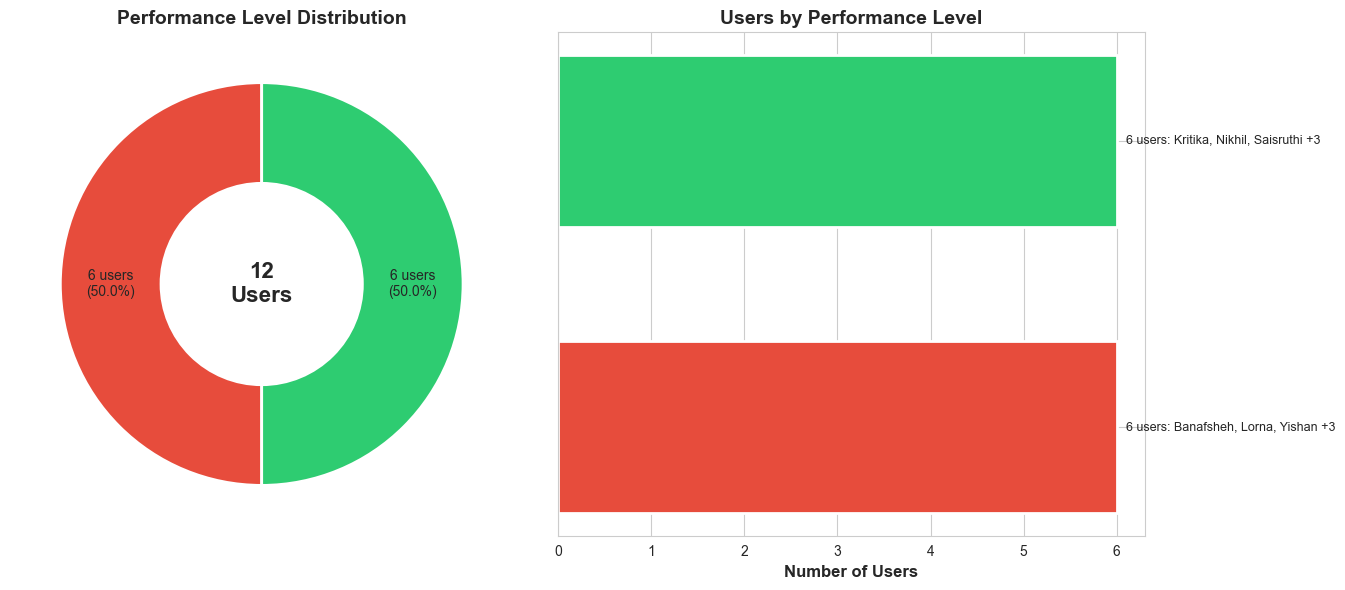

In [15]:
# Chart 4: Achievement Grade Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

grade_counts = performance_df['Achievement_Grade'].value_counts()
non_zero_grades = {k: v for k, v in grade_counts.items() if v > 0}
grades = list(non_zero_grades.keys())
counts = list(non_zero_grades.values())
colors = [GRADE_COLORS[g] for g in grades]

# Donut chart without labels
wedges, texts, autotexts = ax1.pie(counts, colors=colors,
                                    autopct=lambda pct: f'{int(round(pct/100*sum(counts)))} users\n({pct:.1f}%)',
                                    startangle=90, pctdistance=0.75,
                                    wedgeprops={'width': 0.5, 'edgecolor': 'white', 'linewidth': 2})
ax1.text(0, 0, f'{len(performance_df)}\nUsers', ha='center', va='center', fontsize=16, fontweight='bold')
ax1.set_title('Performance Level Distribution', fontsize=14, fontweight='bold')

# Bar chart with first names (no grade labels)
grade_user_mapping = {}
for idx, row in performance_df.iterrows():
    grade = row['Achievement_Grade']
    fname = get_first_name(row['UserName'])
    if grade not in grade_user_mapping:
        grade_user_mapping[grade] = []
    grade_user_mapping[grade].append(fname)

y_pos = np.arange(len(grades))
bars = ax2.barh(y_pos, counts, color=colors, edgecolor='white', linewidth=2, height=0.6)

for i, (bar, grade) in enumerate(zip(bars, grades)):
    users_in_grade = grade_user_mapping.get(grade, [])
    users_str = ', '.join(users_in_grade[:3])
    if len(users_in_grade) > 3:
        users_str += f' +{len(users_in_grade)-3}'
    ax2.text(counts[i] + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{counts[i]} users: {users_str}', va='center', fontsize=9)

ax2.set_yticks(y_pos)
ax2.set_yticklabels([''] * len(grades), fontsize=11)  # Empty labels
ax2.set_xlabel('Number of Users', fontsize=12, fontweight='bold')
ax2.set_title('Users by Performance Level', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'Grade_Distribution_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

# Team

In [8]:
# Load Team.xlsx and examine its structure
import pandas as pd

df_team = pd.read_excel('E:/Dashboard/Team.xlsx')
print("Team.xlsx structure:")
print(f"Shape: {df_team.shape}")
print(f"Columns: {df_team.columns.tolist()}")
print("\nFirst 10 rows:")
print(df_team.head(10))

print("\nColumn data types:")
print(df_team.dtypes)

Team.xlsx structure:
Shape: (38, 4)
Columns: ['First Name', 'Last Name', 'Role', 'Team Function']

First 10 rows:
      First Name         Last Name                       Role Team Function
0       Harinath             Neeli  Project Manager - Quality  Tech Enabler
1       Michael   Uchechukwu Egwim    Pilot & Transition Lead  Tech Enabler
2  Bhagirathsinh           Matroja          Technical Enabler  Tech Enabler
3            Jia              Zhao          Technical Enabler  Tech Enabler
4         Yishan             Zhang          Technical Enabler  Tech Enabler
5          Ramya        Manne Sai           Technical Enabler  Tech Enabler
6          Morna           Nandaia         Delivery Pod Lead   Delivery - A
7         Shahir           Qureshi     Lead GIS Data Engineer  Delivery - A
8          Lorna       Anne Boland              Data Engineer  Delivery - A
9       Hermione            Clarke              Data Engineer  Delivery - A

Column data types:
First Name       object
Last N

In [9]:
# Implement fuzzy name matching algorithm
from difflib import SequenceMatcher

def fuzzy_name_match(performance_name, team_first_name, team_last_name, threshold=0.6):
    """
    Fuzzy matching algorithm for names
    Args:
        performance_name: Name from performance data (e.g., 'morna.nandaia')
        team_first_name: First name from team data (e.g., 'Morna')
        team_last_name: Last name from team data (e.g., 'Nandaia')
        threshold: Similarity threshold (0-1)
    Returns:
        bool: True if match found
    """
    # Clean and prepare names
    perf_name_clean = str(performance_name).lower().replace('.', ' ').replace('_', ' ').strip()
    team_first_clean = str(team_first_name).lower().strip()
    team_last_clean = str(team_last_name).lower().strip()
    team_full_clean = f"{team_first_clean} {team_last_clean}".strip()
    
    # Extract components from performance name
    perf_parts = perf_name_clean.split()
    
    # Method 1: Direct first name matching
    if len(perf_parts) > 0:
        perf_first = perf_parts[0]
        similarity_first = SequenceMatcher(None, perf_first, team_first_clean).ratio()
        if similarity_first >= threshold:
            return True
    
    # Method 2: Check if team first name is contained in performance name
    if team_first_clean in perf_name_clean:
        return True
    
    # Method 3: Check if performance name parts match team names
    for part in perf_parts:
        first_sim = SequenceMatcher(None, part, team_first_clean).ratio()
        last_sim = SequenceMatcher(None, part, team_last_clean).ratio()
        if first_sim >= threshold or last_sim >= threshold:
            return True
    
    # Method 4: Full name similarity
    full_sim = SequenceMatcher(None, perf_name_clean, team_full_clean).ratio()
    if full_sim >= threshold:
        return True
    
    return False

def match_users_to_teams(performance_df, team_df):
    """
    Match performance users to their team functions
    """
    # Create a copy to work with
    matched_df = performance_df.copy()
    matched_df['Team Function'] = 'Unknown'
    matched_df['Matched Team Name'] = 'Unknown'
    matched_df['Match Method'] = 'No Match'
    
    print("Matching process:")
    print("=" * 50)
    
    for idx, perf_row in performance_df.iterrows():
        perf_user = perf_row['UserName']
        best_match = None
        best_similarity = 0
        match_method = 'No Match'
        
        # Try to match with each team member
        for team_idx, team_row in team_df.iterrows():
            team_first = team_row['First Name']
            team_last = team_row['Last Name']
            
            # Try different matching approaches
            if fuzzy_name_match(perf_user, team_first, team_last, threshold=0.6):
                # Calculate overall similarity for best match selection
                perf_clean = str(perf_user).lower().replace('.', ' ')
                team_full = f"{team_first} {team_last}".lower()
                similarity = SequenceMatcher(None, perf_clean, team_full).ratio()
                
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_match = team_row
                    match_method = f'Fuzzy Match (similarity: {similarity:.2f})'
        
        if best_match is not None:
            matched_df.at[idx, 'Team Function'] = best_match['Team Function']
            matched_df.at[idx, 'Matched Team Name'] = f"{best_match['First Name']} {best_match['Last Name']}"
            matched_df.at[idx, 'Match Method'] = match_method
            
            print(f"✓ {perf_user} -> {best_match['First Name']} {best_match['Last Name']} ({best_match['Team Function']}) - {match_method}")
        else:
            print(f"✗ {perf_user} -> No match found")
    
    return matched_df

# Perform the matching
print("Starting name matching process...")
enhanced_performance_df = match_users_to_teams(performance_df, df_team)

# Show matching results
print("\n" + "=" * 60)
print("MATCHING SUMMARY")
print("=" * 60)
matched_count = len(enhanced_performance_df[enhanced_performance_df['Team Function'] != 'Unknown'])
unmatched_count = len(enhanced_performance_df[enhanced_performance_df['Team Function'] == 'Unknown'])

print(f"Successfully matched: {matched_count} users")
print(f"Unmatched: {unmatched_count} users")

print("\nMatching results:")
print(enhanced_performance_df[['UserName', 'Matched Team Name', 'Team Function', 'Match Method']].to_string(index=False))

Starting name matching process...
Matching process:
✓ Banafsheh Goudarzi Nezhad -> Banafsheh Goudarzi Nezhad (Delivery - D) - Fuzzy Match (similarity: 1.00)
✓ Han wang -> Han Wang (Delivery - D) - Fuzzy Match (similarity: 1.00)
✓ Jing Ma -> Maggie Ma (Delivery - D) - Fuzzy Match (similarity: 0.50)
✓ Kritika Adhikari -> Kritika  Adhikari (Delivery - D) - Fuzzy Match (similarity: 0.97)
✓ Lorna Boland -> Lorna Anne Boland (Delivery - A) - Fuzzy Match (similarity: 0.83)
✓ Mahsa Abdolshahnejad -> Mahsa  Abdolshahnejad (Delivery - B) - Fuzzy Match (similarity: 0.98)
✓ Nikhil Muneshwar -> Nikhil  Muneshwar (Delivery - C) - Fuzzy Match (similarity: 0.97)
✓ Saisruthi Dinesh -> Saisruthi Dinesh (Delivery - B) - Fuzzy Match (similarity: 1.00)
✓ Shanthipriya Ninganola -> Shanthipriya Ninganola (Delivery - A) - Fuzzy Match (similarity: 1.00)
✓ Syed Bhukari -> Syed Hamza (Delivery - A) - Fuzzy Match (similarity: 0.64)
✓ Yishan Zhang -> Yishan Zhang (Tech Enabler) - Fuzzy Match (similarity: 1.00)
✓ b

In [10]:
# Team Function Analysis - Group statistics by team
print("\n" + "=" * 60)
print("TEAM FUNCTION ANALYSIS")
print("=" * 60)

# Helper function to extract first name
def get_first_name(full_name):
    """Extract first name from full name"""
    return full_name.split()[0] if isinstance(full_name, str) and full_name.strip() else full_name

# Group by Team Function and calculate statistics
team_stats = []

team_functions = enhanced_performance_df['Team Function'].unique()

for team_func in team_functions:
    if team_func == 'Tech Enabler':
        continue
    team_data = enhanced_performance_df[enhanced_performance_df['Team Function'] == team_func]
    
    # Basic metrics
    user_count = len(team_data)
    total_completed = team_data['Charges_Completed'].sum()
    total_onhold = team_data['Charges_OnHold'].sum()
    total_charges = team_data['Total_Charges'].sum()
    
    # Achievement rate calculation (only for users with targets)
    achievement_values = []
    for val in team_data['Achievement_Rate']:
        if val != "N/A":
            achievement_values.append(float(val.replace('%', '')))
    
    avg_achievement = sum(achievement_values) / len(achievement_values) if achievement_values else None
    users_with_targets = len(achievement_values)
    
    # Time utilization calculation
    time_util_values = []
    for val in team_data['Time_Utilization']:
        if val != "N/A":
            time_util_values.append(float(val.replace('%', '')))
    
    avg_time_util = sum(time_util_values) / len(time_util_values) if time_util_values else None
    
    # Calculate completion rate (completed / total)
    completion_rate = (total_completed / total_charges * 100) if total_charges > 0 else 0
    
    team_stats.append({
        'Team Function': team_func,
        'User Count': user_count,
        'Users List': ', '.join([get_first_name(name) for name in team_data['UserName']]),
        'Total Completed Charges': total_completed,
        'Total OnHold Charges': total_onhold,
        'Total Charges': total_charges,
        'Completion Rate (%)': completion_rate,
        'Avg Achievement Rate (%)': avg_achievement,
        'Users with Targets': users_with_targets,
        'Avg Time Utilization (%)': avg_time_util,
        'Users with Time Targets': len(time_util_values)
    })

# Create team statistics DataFrame
team_stats_df = pd.DataFrame(team_stats)
team_stats_df = team_stats_df.sort_values('Total Charges', ascending=False)

print("Team Function Performance Summary:")
print("=" * 100)

# Display formatted table
for idx, row in team_stats_df.iterrows():
    print(f"\n{row['Team Function'].upper()}")
    print("-" * len(row['Team Function']) + "-" * 5)
    print(f"  Users: {row['User Count']} ({row['Users List']})")
    print(f"  Total Charges: {row['Total Charges']:,.2f}")
    print(f"  Completed: {row['Total Completed Charges']:,.2f} | On-Hold: {row['Total OnHold Charges']:,.2f}")
    print(f"  Completion Rate: {row['Completion Rate (%)']:.1f}%")
    
    if row['Avg Achievement Rate (%)'] is not None:
        print(f"  Avg Achievement Rate: {row['Avg Achievement Rate (%)']:.1f}% ({row['Users with Targets']} users with targets)")
    else:
        print(f"  Avg Achievement Rate: N/A (no users with targets)")
    
    if row['Avg Time Utilization (%)'] is not None:
        print(f"  Avg Time Utilization: {row['Avg Time Utilization (%)']:.1f}% ({row['Users with Time Targets']} users with time targets)")
    else:
        print(f"  Avg Time Utilization: N/A (no users with time targets)")

# Save team statistics
team_report_filename = f'Team_Function_Analysis_{selected_date.replace("-", "")}.xlsx'
team_stats_df.to_excel(team_report_filename, index=False)
print(f"\nTeam analysis report saved to: {team_report_filename}")

# Enhanced individual performance with team info (exclude internal calculation columns)
display_columns = ['UserName', 'Team Function', 'Achievement_Rate', 'Time_Utilization', 
                  'Charges_Completed', 'Total_Charges', 'BatchNames', 'Date', 
                  'Charges_OnHold', 'Target_Time', 'Target_Charges', 'Avg_Time_Per_Charge', 'Achievement_Grade']

# Only include columns that exist in the dataframe
available_display_columns = [col for col in display_columns if col in enhanced_performance_df.columns]
enhanced_performance_df_display = enhanced_performance_df[available_display_columns].copy()

enhanced_report_filename = f'Enhanced_Performance_with_Teams_{selected_date.replace("-", "")}.xlsx'
enhanced_performance_df_display.to_excel(enhanced_report_filename, index=False)
print(f"Enhanced performance report with team info saved to: {enhanced_report_filename}")

print("\n" + "=" * 60)


TEAM FUNCTION ANALYSIS
Team Function Performance Summary:

DELIVERY - A
-----------------
  Users: 6 (Lorna, Shanthipriya, Syed, hermione, kiara, morna.nandaia)
  Total Charges: 515.00
  Completed: 385.00 | On-Hold: 130.00
  Completion Rate: 74.8%
  Avg Achievement Rate: 42.8% (6 users with targets)
  Avg Time Utilization: 46.1% (6 users with time targets)

DELIVERY - D
-----------------
  Users: 6 (Banafsheh, Han, Jing, Kritika, stefanos, tima)
  Total Charges: 458.00
  Completed: 406.00 | On-Hold: 52.00
  Completion Rate: 88.6%
  Avg Achievement Rate: 45.1% (6 users with targets)
  Avg Time Utilization: 43.9% (6 users with time targets)

DELIVERY - B
-----------------
  Users: 4 (Mahsa, Saisruthi, jay, will)
  Total Charges: 345.00
  Completed: 274.00 | On-Hold: 71.00
  Completion Rate: 79.4%
  Avg Achievement Rate: 45.6% (4 users with targets)
  Avg Time Utilization: 45.5% (4 users with time targets)

DELIVERY - C
-----------------
  Users: 2 (Nikhil, olive)
  Total Charges: 158.00

In [11]:
# Check column names and create display dataframe safely
print("Available columns in enhanced_performance_df:")
print(enhanced_performance_df.columns.tolist())

# Create display dataframe with available columns
available_columns = ['UserName', 'Team Function', 'Achievement_Rate', 'Time_Utilization', 
                    'Charges_Completed', 'Total_Charges']

# Only include columns that exist
display_columns = [col for col in available_columns if col in enhanced_performance_df.columns]
enhanced_performance_df_display = enhanced_performance_df[display_columns].copy()

enhanced_report_filename = f'Enhanced_Performance_with_Teams_{selected_date.replace("-", "")}.xlsx'
enhanced_performance_df_display.to_excel(enhanced_report_filename, index=False)
print(f"Enhanced performance report with team info saved to: {enhanced_report_filename}")

# Show sample of enhanced data
print("\nSample of Enhanced Performance Data with Team Information:")
print(enhanced_performance_df_display.head().to_string(index=False))

Available columns in enhanced_performance_df:
['UserName', 'BatchNames', 'Date', 'Charges_Completed', 'Charges_OnHold', 'Total_Charges', 'Target_Time', 'Target_Charges', 'Time_Utilization', 'Achievement_Rate', 'Avg_Time_Per_Charge', 'Achievement_Value', 'Time_Value', 'Achievement_Rank', 'Charges_Rank', 'Achievement_Grade', 'Team Function', 'Matched Team Name', 'Match Method']
Enhanced performance report with team info saved to: Enhanced_Performance_with_Teams_0113.xlsx

Sample of Enhanced Performance Data with Team Information:
                 UserName Team Function Achievement_Rate Time_Utilization  Charges_Completed  Total_Charges
Banafsheh Goudarzi Nezhad  Delivery - D            52.0%            42.0%                 78             84
                 Han wang  Delivery - D             9.3%            10.0%                 14             14
                  Jing Ma  Delivery - D            40.7%            33.3%                 61             61
         Kritika Adhikari  Deliver

Creating Team Performance Visualization...


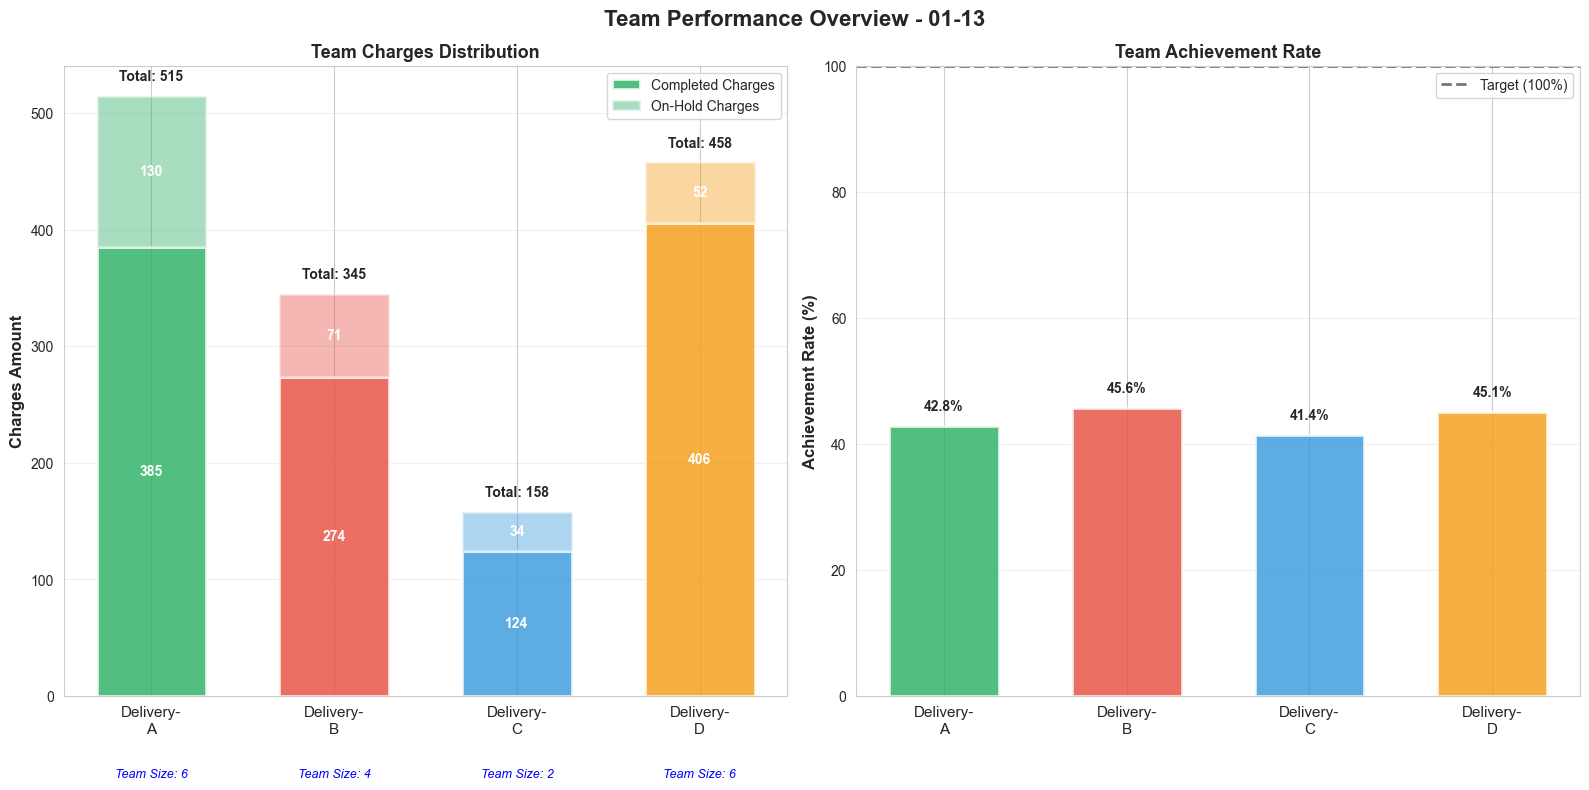

Team Performance Overview chart created!


In [14]:
# 修改后的 Team Performance Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure matplotlib
plt.rcParams['figure.figsize'] = (16, 8)  # 恢复原来的宽度
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

# Define colors for different teams (matching individual performance colors)
TEAM_COLORS = {
    'Delivery - A': '#27ae60',    # Green (for completed charges)
    'Delivery - B': '#e74c3c',    # Red  
    'Delivery - C': '#3498db',    # Blue
    'Delivery - D': '#f39c12',    # Orange
    'Tech Enabler': '#9b59b6',    # Purple
    'Unknown': '#95a5a6'          # Gray
}

print("Creating Team Performance Visualization...")
print("=" * 50)

# Team Performance Overview with separated charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'Team Performance Overview - {selected_date}', fontsize=16, fontweight='bold')

# Get data and sort by ABCD order
team_order = ['Delivery - A', 'Delivery - B', 'Delivery - C', 'Delivery - D', 'Tech Enabler', 'Unknown']
team_stats_sorted = team_stats_df.set_index('Team Function').reindex([t for t in team_order if t in team_stats_df['Team Function'].values]).reset_index()

teams = team_stats_sorted['Team Function'].tolist()
completed_charges = team_stats_sorted['Total Completed Charges'].tolist()
onhold_charges = team_stats_sorted['Total OnHold Charges'].tolist()
total_charges = team_stats_sorted['Total Charges'].tolist()
achievement_rates = [row['Avg Achievement Rate (%)'] if row['Avg Achievement Rate (%)'] is not None else 0 
                    for _, row in team_stats_sorted.iterrows()]
user_counts = team_stats_sorted['User Count'].tolist()

# 恢复原来的团队间距
x_pos = np.arange(len(teams))  # 恢复原来的间距
width = 0.6

# Panel 1: Team Charges Distribution (Stacked Bar like Individual Style)
for i, team in enumerate(teams):
    team_color = TEAM_COLORS.get(team, '#95a5a6')
    
    # Completed charges (solid color)
    bars1 = ax1.bar(x_pos[i], completed_charges[i], width, 
                   color=team_color, alpha=0.8, edgecolor='white', linewidth=2,
                   label='Completed Charges' if i == 0 else "")
    
    # On-Hold charges (lighter color)
    bars2 = ax1.bar(x_pos[i], onhold_charges[i], width, bottom=completed_charges[i],
                   color=team_color, alpha=0.4, edgecolor='white', linewidth=2,
                   label='On-Hold Charges' if i == 0 else "")

# Add value labels on bars for Panel 1
for i, (comp, hold, total, users) in enumerate(zip(completed_charges, onhold_charges, total_charges, user_counts)):
    # Completed charges label
    if comp > 0:
        ax1.text(x_pos[i], comp/2, f'{comp:.0f}', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    # On-Hold charges label
    if hold > 0:
        ax1.text(x_pos[i], comp + hold/2, f'{hold:.0f}', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    
    # Total at top
    ax1.text(x_pos[i], total + max(total_charges)*0.02, f'Total: {total:.0f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Team size at bottom (below x-axis with more distance)
    ax1.text(x_pos[i], -max(total_charges)*0.12, f'Team Size: {users}', 
            ha='center', va='top', fontsize=9, style='italic', color='blue')

ax1.set_xticks(x_pos)
ax1.set_xticklabels([team.replace(' - ', '-\n') for team in teams], fontsize=11, rotation=0)
ax1.set_ylabel('Charges Amount', fontsize=12, fontweight='bold')
ax1.set_title('Team Charges Distribution', fontweight='bold', fontsize=13)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Team Achievement Rate Bar Chart
colors_achievement = [TEAM_COLORS.get(team, '#95a5a6') for team in teams]
bars_achievement = ax2.bar(x_pos, achievement_rates, width, color=colors_achievement, 
                          alpha=0.8, edgecolor='white', linewidth=2)

# Add target line
ax2.axhline(y=100, color='#2c3e50', linestyle='--', linewidth=2, alpha=0.7, label='Target (100%)')

# Add value labels for achievement rates (without team size)
for i, (rate) in enumerate(achievement_rates):
    if rate > 0:
        ax2.text(x_pos[i], rate + 2, f'{rate:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        ax2.text(x_pos[i], 5, 'N/A', 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='gray')

ax2.set_xticks(x_pos)
ax2.set_xticklabels([team.replace(' - ', '-\n') for team in teams], fontsize=11, rotation=0)
ax2.set_ylabel('Achievement Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Team Achievement Rate', fontweight='bold', fontsize=13)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
# 固定纵坐标范围为0-100%
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(f'Team_Performance_Overview_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

print("Team Performance Overview chart created!")

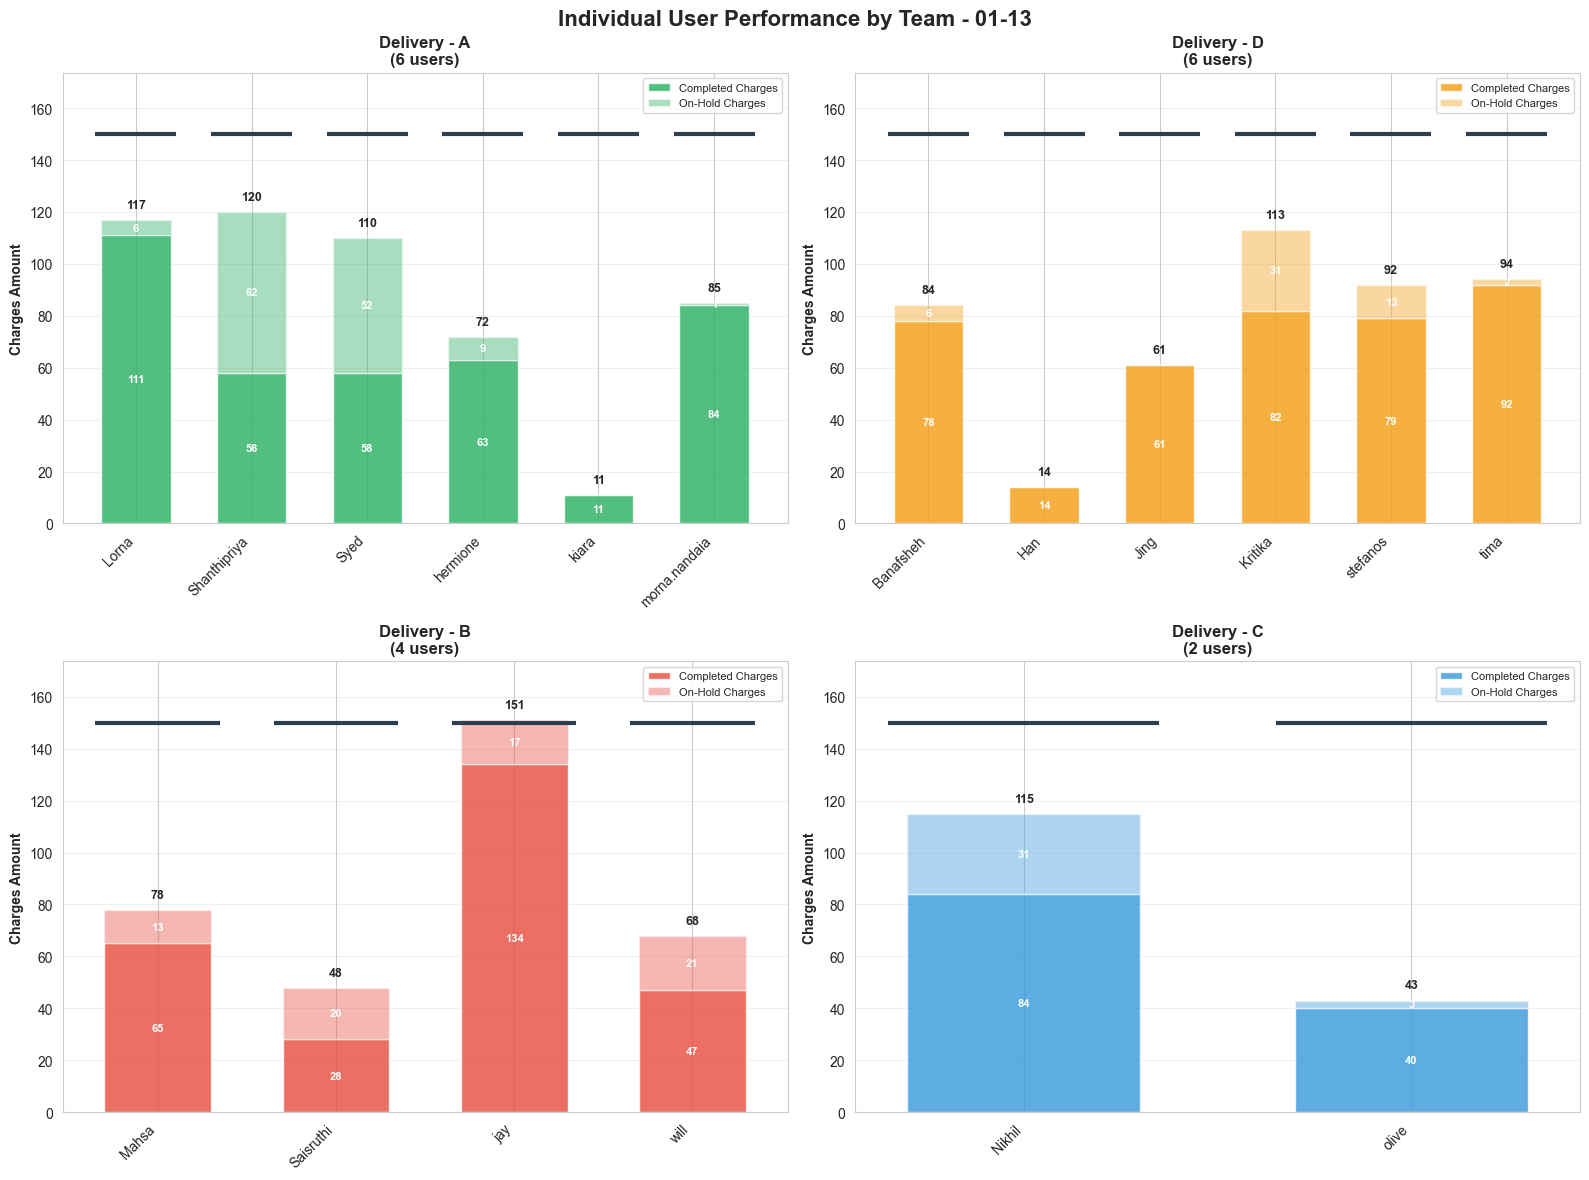

Individual Performance by Team chart created!


In [14]:
# Chart 2: Individual User Performance by Team (Charges Distribution Style)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Individual User Performance by Team - {selected_date}', fontsize=16, fontweight='bold')

axes = axes.flatten()

# Get teams (excluding Unknown and Tech Enabler)
teams_for_detailed = [team for team in teams if team not in ['Unknown', 'Tech Enabler']]
teams_for_detailed = teams_for_detailed[:4]  # Maximum 4 teams for the 2x2 layout

# Calculate global max value for unified y-axis
global_max_charges = 0
for team in teams_for_detailed:
    team_data = enhanced_performance_df[enhanced_performance_df['Team Function'] == team]
    team_max = team_data['Total_Charges'].max() if len(team_data) > 0 else 0
    global_max_charges = max(global_max_charges, team_max)

# Add 15% buffer for unified y-axis
unified_y_limit = global_max_charges * 1.15 if global_max_charges > 0 else 100

for idx, team in enumerate(teams_for_detailed):
    ax = axes[idx]
    team_data = enhanced_performance_df[enhanced_performance_df['Team Function'] == team]
    
    # Get user data
    user_names = [get_first_name(name) for name in team_data['UserName']]
    completed_charges = team_data['Charges_Completed'].tolist()
    onhold_charges = team_data['Charges_OnHold'].tolist()
    total_charges = team_data['Total_Charges'].tolist()
    
    # Get target charges for line markers
    target_charges_list = []
    for val in team_data['Target_Charges']:
        target_charges_list.append(float(val) if val != "N/A" else None)
    
    x_pos = np.arange(len(user_names))
    width = 0.6
    
    # Team color
    team_color = TEAM_COLORS.get(team, '#95a5a6')
    
    # Create stacked bars like Charges_Distribution
    bars1 = ax.bar(x_pos, completed_charges, width, label='Completed Charges', 
                   color=team_color, alpha=0.8, edgecolor='white', linewidth=1)
    bars2 = ax.bar(x_pos, onhold_charges, width, bottom=completed_charges, 
                   label='On-Hold Charges', color=team_color, alpha=0.4, edgecolor='white', linewidth=1)
    
    # Add target line markers
    for i, target in enumerate(target_charges_list):
        if target is not None:
            ax.hlines(y=target, xmin=i-0.35, xmax=i+0.35, color='#2c3e50', linewidth=3, linestyle='-')
    
    # Add value labels with standardized formatting
    for i, (comp, hold, total) in enumerate(zip(completed_charges, onhold_charges, total_charges)):
        if comp > 0:
            ax.text(i, comp/2, f'{comp:.0f}', ha='center', va='center', 
                    fontsize=8, fontweight='bold', color='white')
        if hold > 0:
            ax.text(i, comp + hold/2, f'{hold:.0f}', ha='center', va='center', 
                    fontsize=8, fontweight='bold', color='white')
        # Total at top with standardized positioning
        ax.text(i, total + unified_y_limit*0.02, f'{total:.0f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # Set unified y-axis limit for all subplots
    ax.set_ylim(0, unified_y_limit)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(user_names, fontsize=10, rotation=45, ha='right')
    ax.set_ylabel('Charges Amount', fontweight='bold', fontsize=10)
    ax.set_title(f'{team}\n({len(user_names)} users)', fontweight='bold', fontsize=12)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

# Hide empty subplots
for idx in range(len(teams_for_detailed), len(axes)):·

plt.tight_layout()
plt.savefig(f'Individual_Performance_by_Team_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

print("Individual Performance by Team chart created!")

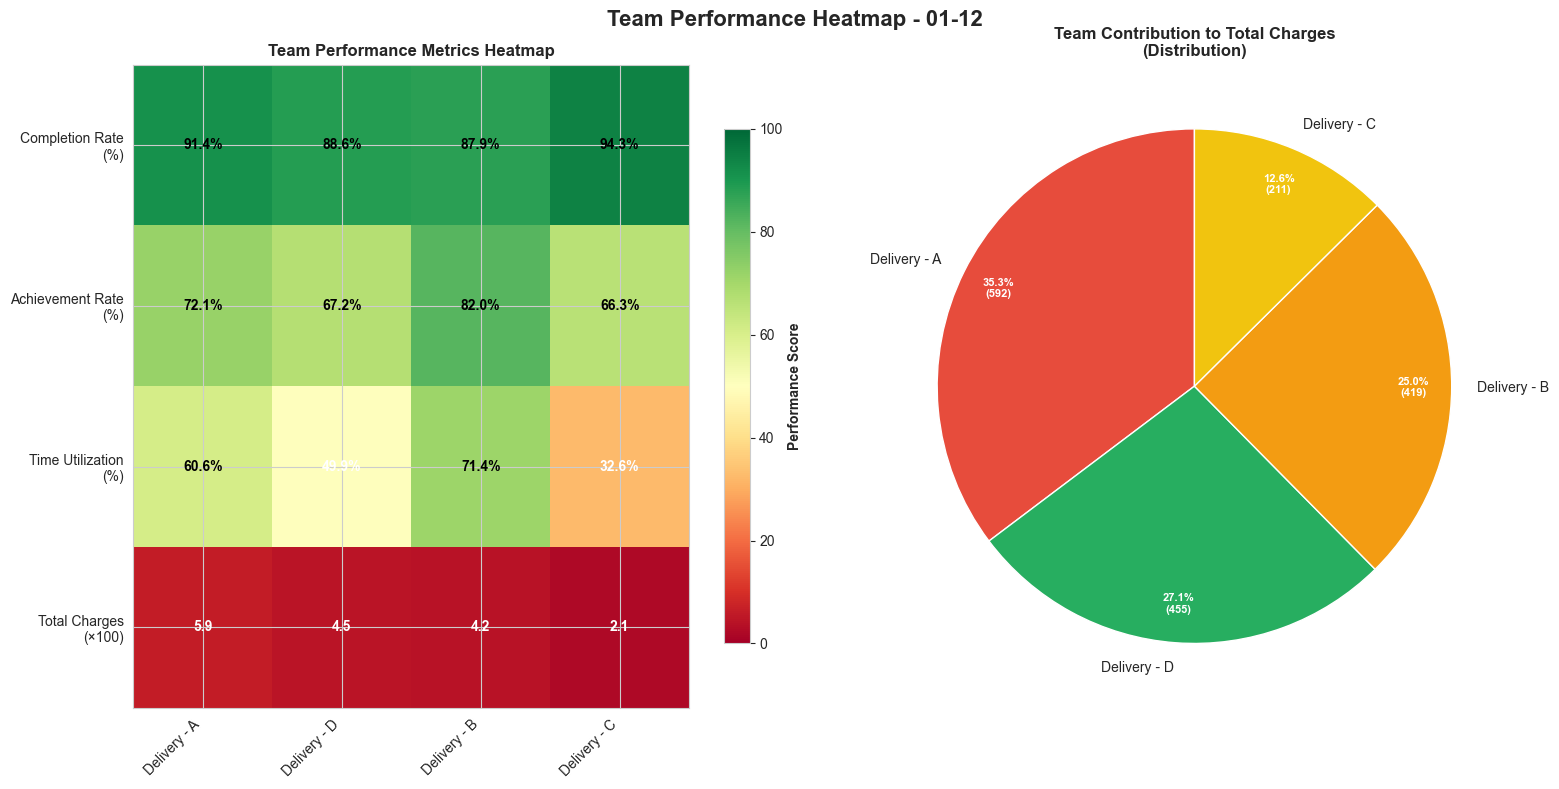

Team Performance Heatmap created!


In [ ]:
# Chart 3: Team Performance Heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'Team Performance Heatmap - {selected_date}', fontsize=16, fontweight='bold')

# Prepare data for heatmap
team_metrics = []
team_names = []

for _, row in team_stats_df.iterrows():
    if row['Team Function'] not in ['Unknown', 'Tech Enabler']:
        team_names.append(row['Team Function'])
        metrics = [
            row['Completion Rate (%)'],
            row['Avg Achievement Rate (%)'] if row['Avg Achievement Rate (%)'] is not None else 0,
            row['Avg Time Utilization (%)'] if row['Avg Time Utilization (%)'] is not None else 0,
            row['Total Charges'] / 100  # Scale down for better visualization
        ]
        team_metrics.append(metrics)

metric_names = ['Completion Rate\n(%)', 'Achievement Rate\n(%)', 'Time Utilization\n(%)', 'Total Charges\n(×100)']

# Create heatmap 1: Performance metrics
heatmap_data = np.array(team_metrics)
im1 = ax1.imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

ax1.set_xticks(range(len(team_names)))
ax1.set_xticklabels(team_names, rotation=45, ha='right')
ax1.set_yticks(range(len(metric_names)))
ax1.set_yticklabels(metric_names)
ax1.set_title('Team Performance Metrics Heatmap', fontweight='bold')

# Add text annotations
for i in range(len(metric_names)):
    for j in range(len(team_names)):
        if i == 3:  # Total charges
            text = f'{heatmap_data[j, i]:.1f}'
        else:
            text = f'{heatmap_data[j, i]:.1f}%'
        ax1.text(j, i, text, ha='center', va='center', fontweight='bold', 
                color='white' if heatmap_data[j, i] < 50 else 'black')

# Create colorbar
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Performance Score', fontweight='bold')

# Create performance matrix for visualization
user_team_matrix = []
all_users = []

for team in team_names:
    team_data = enhanced_performance_df[enhanced_performance_df['Team Function'] == team]
    for _, user_row in team_data.iterrows():
        all_users.append(get_first_name(user_row['UserName']))
        achievement = float(user_row['Achievement_Rate'].replace('%', '')) if user_row['Achievement_Rate'] != "N/A" else 0
        time_util = float(user_row['Time_Utilization'].replace('%', '')) if user_row['Time_Utilization'] != "N/A" else 0
        charges = user_row['Total_Charges']
        user_team_matrix.append([team, achievement, time_util, charges])

# Chart 4: Summary statistics (excluding Tech Enabler)
teams_summary = team_stats_df[~team_stats_df['Team Function'].isin(['Unknown', 'Tech Enabler'])]
labels = teams_summary['Team Function'].tolist()
sizes = teams_summary['Total Charges'].tolist()
colors = [TEAM_COLORS.get(label, '#95a5a6') for label in labels]

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors,
                                   autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes)):,.0f})',
                                   startangle=90, pctdistance=0.85)

ax2.set_title('Team Contribution to Total Charges\n(Distribution)', fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)

plt.tight_layout()
plt.savefig(f'Team_Heatmap_Analysis_{selected_date.replace("-", "")}.png', dpi=150, bbox_inches='tight')
plt.show()

print("Team Performance Heatmap created!")

In [30]:
# Final Team Analysis Summary and Recommendations
print("\n" + "=" * 80)
print("COMPREHENSIVE TEAM FUNCTION ANALYSIS SUMMARY")
print("=" * 80)
print(f"Analysis Date: {selected_date}")
print(f"Total Users Analyzed: {len(enhanced_performance_df)}")
print(f"Successfully Matched to Teams: {len(enhanced_performance_df[enhanced_performance_df['Team Function'] != 'Unknown'])}")

print("\n📊 KEY FINDINGS:")
print("-" * 40)

# Find best and worst performing teams (excluding Tech Enabler)
team_performance_ranking = team_stats_df[team_stats_df['Team Function'] != 'Tech Enabler'].sort_values('Avg Achievement Rate (%)', ascending=False)
best_team = team_performance_ranking.iloc[0]
worst_team = team_performance_ranking.iloc[-1]

print(f"🏆 HIGHEST ACHIEVING TEAM: {best_team['Team Function']}")
print(f"   - Average Achievement Rate: {best_team['Avg Achievement Rate (%)']:.1f}%")
print(f"   - Completion Rate: {best_team['Completion Rate (%)']:.1f}%")
print(f"   - Team Size: {best_team['User Count']} users")
print(f"   - Total Charges: {best_team['Total Charges']:,.0f}")

print(f"\n⚠️  NEEDS ATTENTION: {worst_team['Team Function']}")
print(f"   - Average Achievement Rate: {worst_team['Avg Achievement Rate (%)']:.1f}%")
print(f"   - Completion Rate: {worst_team['Completion Rate (%)']:.1f}%")
print(f"   - Team Size: {worst_team['User Count']} users")
print(f"   - Total Charges: {worst_team['Total Charges']:,.0f}")

print("\n🎯 TEAM PERFORMANCE INSIGHTS:")
print("-" * 40)

# Team insights
for _, team_row in team_stats_df.iterrows():
    if team_row['Team Function'] not in ['Unknown', 'Tech Enabler']:
        team_name = team_row['Team Function']
        achievement = team_row['Avg Achievement Rate (%)']
        completion = team_row['Completion Rate (%)']
        
        # Performance assessment
        if achievement and achievement >= 80:
            perf_status = "🟢 Excellent"
        elif achievement and achievement >= 60:
            perf_status = "🟡 Good"
        elif achievement and achievement >= 40:
            perf_status = "🟠 Fair"
        else:
            perf_status = "🔴 Needs Improvement"
        
        print(f"\n{team_name}: {perf_status}")
        print(f"  • Achievement: {achievement:.1f}% | Completion: {completion:.1f}%")
        
        # Specific insights
        if achievement and achievement >= 100:
            print(f"  • ✅ Meeting/exceeding targets consistently")
        elif achievement and achievement < 50:
            print(f"  • ❌ Significantly below target - requires immediate attention")
        
        if completion >= 95:
            print(f"  • ✅ Excellent completion rate - minimal on-hold tasks")
        elif completion < 85:
            print(f"  • ⚠️  High on-hold ratio - may need process optimization")

print("\n📈 RECOMMENDATIONS:")
print("-" * 40)

# Generate specific recommendations
recommendations = []

# For underperforming teams (excluding Tech Enabler)
underperforming_teams = team_stats_df[
    (team_stats_df['Avg Achievement Rate (%)'].notna()) & 
    (team_stats_df['Avg Achievement Rate (%)'] < 60) &
    (team_stats_df['Team Function'] != 'Tech Enabler')
]['Team Function'].tolist()

if underperforming_teams:
    recommendations.append(f"🎯 Priority Action: Focus on {', '.join(underperforming_teams)} - implement targeted training and support")

# For high completion rate but low achievement (excluding Tech Enabler)
efficient_but_low_achievers = team_stats_df[
    (team_stats_df['Completion Rate (%)'] >= 90) & 
    (team_stats_df['Avg Achievement Rate (%)'].notna()) & 
    (team_stats_df['Avg Achievement Rate (%)'] < 70) &
    (team_stats_df['Team Function'] != 'Tech Enabler')
]['Team Function'].tolist()

if efficient_but_low_achievers:
    recommendations.append(f"📊 Review targets for {', '.join(efficient_but_low_achievers)} - may need realistic target adjustment")

# For high achievement but low completion (excluding Tech Enabler)
high_achievers_with_quality_issues = team_stats_df[
    (team_stats_df['Avg Achievement Rate (%)'].notna()) & 
    (team_stats_df['Avg Achievement Rate (%)'] >= 80) & 
    (team_stats_df['Completion Rate (%)'] < 90) &
    (team_stats_df['Team Function'] != 'Tech Enabler')
]['Team Function'].tolist()

if high_achievers_with_quality_issues:
    recommendations.append(f"⚖️  Quality focus for {', '.join(high_achievers_with_quality_issues)} - balance speed with completion rate")

# Best practices sharing (excluding Tech Enabler)
best_teams = team_stats_df[
    (team_stats_df['Avg Achievement Rate (%)'].notna()) & 
    (team_stats_df['Avg Achievement Rate (%)'] >= 75) &
    (team_stats_df['Completion Rate (%)'] >= 90) &
    (team_stats_df['Team Function'] != 'Tech Enabler')
]['Team Function'].tolist()

if best_teams:
    recommendations.append(f"🌟 Share best practices from {', '.join(best_teams)} with other teams")

# General recommendations
recommendations.extend([
    "📋 Regular team performance review meetings to discuss metrics",
    "🎯 Set realistic but challenging targets based on team capabilities",
    "📊 Monitor completion rates to maintain quality standards",
    "🤝 Cross-team collaboration to share effective strategies"
])

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n💾 GENERATED REPORTS:")
print("-" * 40)
print(f"✅ Team Function Analysis: {team_report_filename}")
print(f"✅ Enhanced Performance Report: {enhanced_report_filename}")
print(f"✅ Visualization Charts: Multiple PNG files saved")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


COMPREHENSIVE TEAM FUNCTION ANALYSIS SUMMARY
Analysis Date: 01-12
Total Users Analyzed: 17
Successfully Matched to Teams: 17

📊 KEY FINDINGS:
----------------------------------------
🏆 HIGHEST ACHIEVING TEAM: Delivery - B
   - Average Achievement Rate: 82.0%
   - Completion Rate: 87.9%
   - Team Size: 3 users
   - Total Charges: 420

⚠️  NEEDS ATTENTION: Delivery - C
   - Average Achievement Rate: 66.3%
   - Completion Rate: 94.3%
   - Team Size: 2 users
   - Total Charges: 211

🎯 TEAM PERFORMANCE INSIGHTS:
----------------------------------------

Delivery - A: 🟡 Good
  • Achievement: 72.1% | Completion: 91.4%

Delivery - D: 🟡 Good
  • Achievement: 67.2% | Completion: 88.6%

Delivery - B: 🟢 Excellent
  • Achievement: 82.0% | Completion: 87.9%

Delivery - C: 🟡 Good
  • Achievement: 66.3% | Completion: 94.3%

📈 RECOMMENDATIONS:
----------------------------------------
1. 📊 Review targets for Delivery - C - may need realistic target adjustment
2. ⚖️  Quality focus for Delivery - B - bal